In [1]:
import pandas as pd
import os
import json
import numpy as np
import torch
from steams.data.KVyQVx import KVyQVx
from steams.models.mads import mads
from steams.tepe.steams import attention_steams
from steams.tepe.tepe import train, evaluation,prediction_prime,ensemble_prime
from steams.utils.criterion import R2,RMSE,variance
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))

In [3]:
resdir = os.path.join(parent_dir,'results')
figdir = os.path.join(parent_dir,'fig')
if not os.path.exists(figdir):
    os.makedirs(figdir)
if not os.path.exists(resdir):
    os.makedirs(resdir)

In [4]:
if torch.cuda.is_available():
    cuda_name = "1"
    num_workers=0
    pin_memory = True
    device = torch.device('cuda'+":"+cuda_name)
else:
    num_workers = 0
    pin_memory = False
    device = torch.device('cpu')

In [5]:
device

device(type='cpu')

## train/valid dataset

In [6]:
params = {
        "class" : "KVyQVx",
        "Y":{
          "path": "",
          "KEY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "history_length": 0,
          "nb_sampling": 100
        },
        "X":{
          "path": "",
          "QUERY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "gap_length": 0,
          "horizon_length":0,
          "nb_sampling": 100
        }
    }

In [7]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_train")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_train")

train_dataset = KVyQVx(params)

In [8]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_valid")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_valid")

valid_dataset = KVyQVx(params)

## model, optimizer, criterion, scheduler

In [9]:
#model
model = mads(device,type="nwd",kernel="gauss",input_k=2)

In [10]:
# optimzer
optimizer = torch.optim.Adam([model.W], lr=1e-2) #8e-3

# criterion
criterion = torch.nn.MSELoss()

# steams object
obj = attention_steams(model,device)
obj.init_optimizer(optimizer)
obj.init_criterion(criterion)

## Training

In [11]:
# training
train(obj,train_dataset,valid_dataset,niter=10,n_iter_stop=20,batch_size=1,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

  epoch    train     valid
0     0  0.33824  0.202428
  epoch     train     valid
0     1  0.216002  0.190434
  epoch     train     valid
0     2  0.211472  0.195826
  epoch     train     valid
0     3  0.214757  0.192515
  epoch    train     valid
0     4  0.21611  0.192298
  epoch    train     valid
0     5  0.21585  0.192693
  epoch     train     valid
0     6  0.218921  0.196227
  epoch     train    valid
0     7  0.213265  0.19285
  epoch     train     valid
0     8  0.215168  0.191959
  epoch     train    valid
0     9  0.214672  0.19594


In [12]:
obj.save_model(resdir,"1b-nwd")

## Evaluation

In [13]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [14]:
criterion = R2()
#criterion = torch.nn.MSELoss()
obj.init_criterion(criterion)

In [15]:
evaluation(obj,eval_dataset,batch_size=1,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.7073757535815239


In [16]:
criterion = RMSE()
obj.init_criterion(criterion)

In [17]:
evaluation(obj,eval_dataset,batch_size=1,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.23180671013891696


In [18]:
criterion = variance()
obj.init_criterion(criterion)

In [19]:
evaluation(obj,eval_dataset,batch_size=1,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.03245196770504117


## QQplot

In [20]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [21]:
results = prediction_prime(obj,eval_dataset)

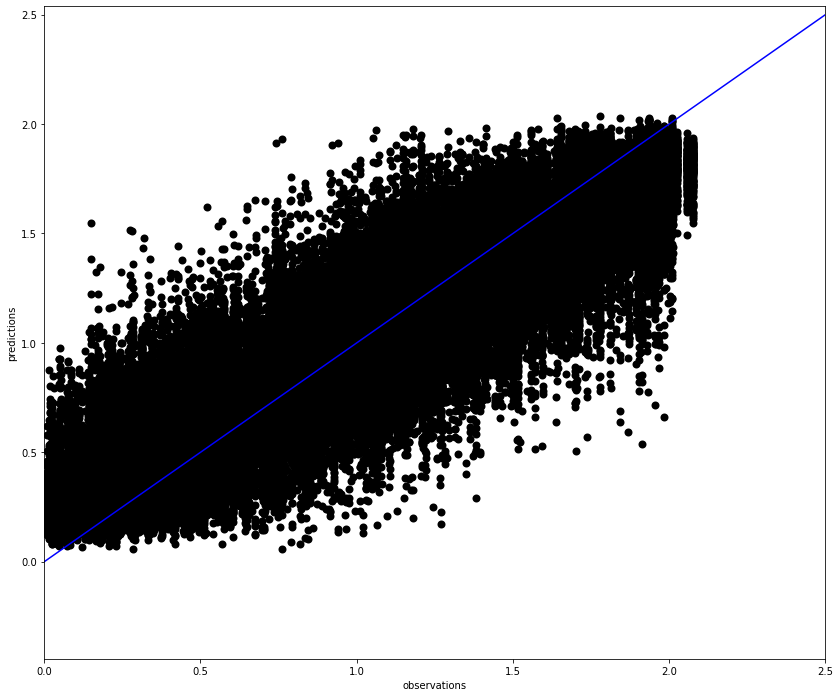

In [22]:
pred_name = ['pred_' + v for v in eval_dataset.VALUE_X]

fig, ax= plt.subplots(figsize=(14, 12))
ax.scatter(results.loc[:,eval_dataset.VALUE_X],results.loc[:,pred_name], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
ax.set_xlim(0, 2.5)
ax.set_ylim(results.loc[:,pred_name].min().item()-0.5, results.loc[:,pred_name].max().item()+0.5)
ax.set(xlabel='observations', ylabel='predictions')

fig_filename = os.path.join(parent_dir,'fig','1b-qqplot.png')
plt.savefig(fig_filename, dpi = 300)

## Wq

In [23]:
W = obj.model.W.detach()
W

tensor([6.0962, 6.1725])

## ensemble, quantiles and p-value 

In [24]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [25]:
# !! might take some time
ensemble = ensemble_prime(obj,eval_dataset,N=2)

In [26]:
ensemble.to_csv(os.path.join(resdir,'1b-ensemble.csv'))

### metrics

In [27]:
obs = torch.tensor(ensemble[('sensor_hq', 'mean')].to_numpy())
obs = torch.reshape(obs,(1,obs.shape[0],1))
q0_5 = torch.tensor(ensemble[('pred_sensor_hq','q0_5')].to_numpy())
q0_5 = torch.reshape(q0_5,(1,q0_5.shape[0],1))

In [28]:
criterion = R2()
criterion(obs,q0_5)

tensor(0.8672)

In [29]:
criterion = RMSE()
criterion(obs,q0_5)

tensor(0.1501)

In [30]:
criterion = variance()
criterion(obs,q0_5)

tensor(0.0159)

### qqplot of the observation against the median of the ensemble at each location

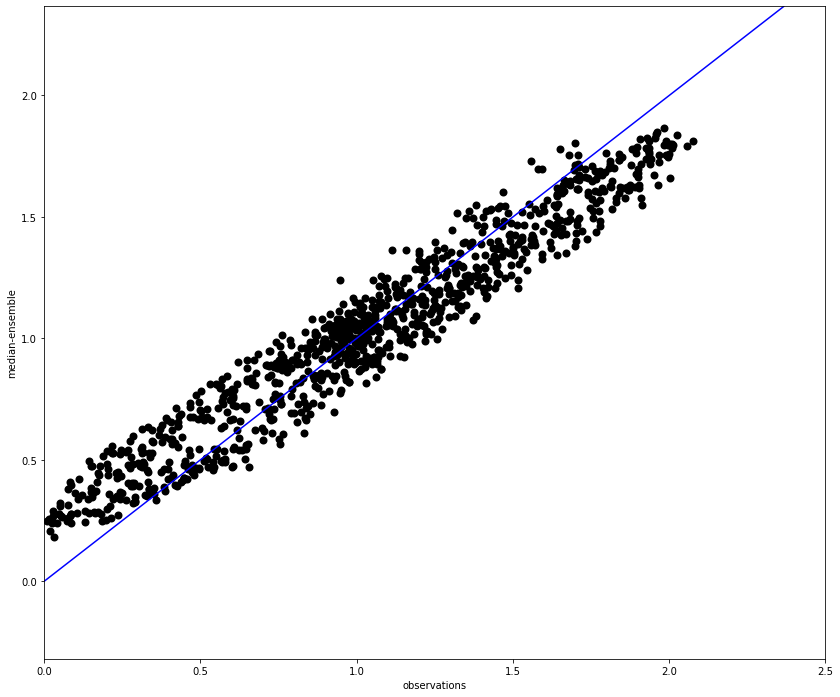

In [31]:
fig, ax= plt.subplots(figsize=(14, 12))
ax.scatter(ensemble[('sensor_hq', 'mean')],ensemble[('pred_sensor_hq','q0_5')], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
ax.set_xlim(0, 2.5)
ax.set_ylim(ensemble[('pred_sensor_hq','q0_5')].min().item()-0.5, ensemble[('pred_sensor_hq','q0_5')].max().item()+0.5)
ax.set(xlabel='observations', ylabel='median-ensemble')

fig_filename = os.path.join(parent_dir,'fig','1b-ensemble_q0_5_qqplot.png')
plt.savefig(fig_filename, dpi = 300)

### p-qqplot of the p-value of the obsevration within its ensemble against an uniform distribution

More explanation, here: https://www.mdpi.com/1424-8220/21/6/2160/htm

In [32]:
ensemble = ensemble.sort_values(by='p_sensor_hq')
ensemble["U"] = np.linspace(0, 1, num=ensemble.shape[0])    

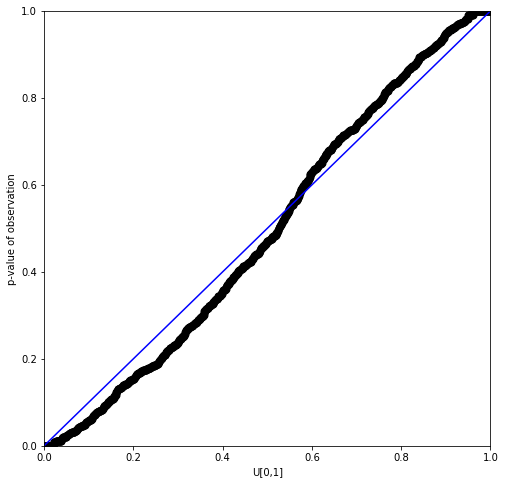

In [33]:
fig, ax= plt.subplots(figsize=(8, 8))
ax.scatter(ensemble['U'],ensemble['p_sensor_hq'], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
ax.set_xlim(0, 1)
ax.set_ylim(0,1)
ax.set(xlabel='U[0,1]', ylabel='p-value of observation')

fig_filename = os.path.join(parent_dir,'fig','1b-p_qqplot.png')
plt.savefig(fig_filename, dpi = 300)

## Illustration of median-quantile 0.05 and median - quantile 0.95 on maps

In [34]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_sensor_6400")
params['X']['nb_location'] = 6400

eval_dataset = KVyQVx(params)

In [35]:
# !! might take some time
ensemble = ensemble_prime(obj,eval_dataset,N=2)

In [36]:
vmax = np.array(
    np.abs(np.array([ensemble[('pred_sensor_hq','q0_05')] - ensemble[('pred_sensor_hq','q0_5')]])).max(),
    np.array([ensemble[('pred_sensor_hq','q0_95')] - ensemble[('pred_sensor_hq','q0_5')]]).max()).max()


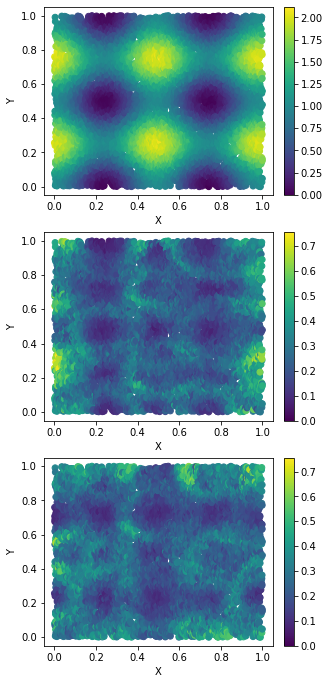

In [37]:
fig = plt.figure(constrained_layout=True,figsize=(14, 12))
gs = GridSpec(4, 4, figure=fig)

ax0 = fig.add_subplot(gs[0,0])
c0 = ax0.scatter(x=ensemble["x"], y=ensemble["y"], c=ensemble[('sensor_hq', 'mean')])
ax0.set(ylabel='Y',xlabel='X')

ax1 = fig.add_subplot(gs[1,0])
c1 = ax1.scatter(x=ensemble["x"], y=ensemble["y"], c=np.abs(ensemble[('pred_sensor_hq', 'q0_05')]- ensemble[('pred_sensor_hq', 'q0_5')]), vmin = 0, vmax=vmax)
ax1.set(ylabel='Y',xlabel='X')

ax2 = fig.add_subplot(gs[2,0])
c2 = ax2.scatter(x=ensemble["x"], y=ensemble["y"], c=ensemble[('pred_sensor_hq', 'q0_95')] - ensemble[('pred_sensor_hq', 'q0_5')], vmin = 0, vmax=vmax)
ax2.set(ylabel='Y',xlabel='X')


fig.colorbar(c0, ax=ax0)
fig.colorbar(c1, ax=ax1)
fig.colorbar(c2, ax=ax2)

fig_filename = os.path.join(parent_dir,'fig','1b-illustration_diff_median-q005_and_median-q095.png')
plt.savefig(fig_filename, dpi = 300)
